## Set up Enviroment by enabling the current workspace venv

In [18]:
!pip freeze

asttokens==3.0.0
colorama==0.4.6
comm==0.2.2
contourpy==1.3.1
cycler==0.12.1
debugpy==1.8.12
decorator==5.2.1
executing==2.2.0
fonttools==4.56.0
imageio==2.37.0
ipykernel==6.29.5
ipython==8.32.0
jedi==0.19.2
jupyter_client==8.6.3
jupyter_core==5.7.2
kiwisolver==1.4.8
matplotlib==3.10.0
matplotlib-inline==0.1.7
nest-asyncio==1.6.0
numpy==2.2.3
packaging==24.2
pandas==2.2.3
parso==0.8.4
pillow==11.1.0
platformdirs==4.3.6
prompt_toolkit==3.0.50
psutil==7.0.0
pure_eval==0.2.3
Pygments==2.19.1
pyparsing==3.2.1
python-dateutil==2.9.0.post0
pytz==2025.1
pywin32==308
pyzmq==26.2.1
scipy==1.15.2
six==1.17.0
stack-data==0.6.3
tornado==6.4.2
tqdm==4.67.1
traitlets==5.14.3
tzdata==2025.1
wcwidth==0.2.13


In [19]:
!pip install matplotlib
!pip install numpy
!pip install pandas
!pip install tqdm
!pip install scipy
!pip install imageio

## Initialize some values
Here is how we are going to set this up, the entire map will be from {0<=x<=1} {0<=y<=1} 
The heruistic map will be split using the mapResolution variable to then split this 1x1 grid into sections to then generate a aproximated heruistic

In [20]:
#import libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from tqdm import tqdm
import time

#Heuristic map
mapResolution = 16
heuristicMap = np.zeros((mapResolution, mapResolution))

#Start and Goal
start = (0, 0)
goal = (1, 1)

#Goal range
goalRange = 0.05
distanceUnit = 0.05

## Set up some Functions

In [21]:
#corodinates to heuristic map index *not sure if this is needed
def coord2heuristic(x, y):
    if x > 1 or x < 0 or y > 1 or y < 0:
        print(f"Error: x and y must be within the range [0, 1]")
        raise ValueError
    return (round(x*mapResolution) , round(y*mapResolution))

#heuristic map index to coordinate within that cell, random uniform distribution within cell
def heuristic2coord(x, y):
    #x and y cannot be larger or equal to mapResolution
    if x >= mapResolution or y >= mapResolution:
        print(f"Error: x and y cannot be larger or equal to mapResolution: {mapResolution}")
        raise ValueError
    return (np.random.uniform(x/mapResolution, (x+1)/mapResolution), np.random.uniform(y/mapResolution, (y+1)/mapResolution))

# Function to normalize heuristic map (0-1) then convert to probability distribution
def normalize_to_probability(heuristic_map):
    # Step 1: Linear Normalization (0 to 1)
    min_val, max_val = np.min(heuristic_map), np.max(heuristic_map)
    linear_norm = (heuristic_map - min_val) / (max_val - min_val)  # Scale to [0,1]

    # Step 2: Normalize so it sums to 1 (Probability Distribution)
    return linear_norm / np.sum(linear_norm)

# Function to pick a weighted random cell
def pick_weighted_random_cell(heuristic_map):
    # Normalize and convert to probability distribution in one step
    normalized_map = normalize_to_probability(heuristic_map)
    
    # Flatten for random selection
    flat_map = normalized_map.flatten()
    
    # Pick a random cell based on probability
    index = np.random.choice(len(flat_map), p=flat_map)
    return np.unravel_index(index, heuristic_map.shape)  # Convert back to 2D index

# Euclidean distance heuristic function
def euclidean_distance_heuristic(x, y, goal):
    return np.sqrt(2) - np.sqrt((x - goal[0])**2 + (y - goal[1])**2)

def pick_pure_random_point():
    return (np.random.uniform(0, 1), np.random.uniform(0, 1))

## Initialize heuristic

In [22]:
for i in tqdm(range(mapResolution)):
    for j in range(mapResolution):
        heuristicMap[i, j] = euclidean_distance_heuristic(i/mapResolution, j/mapResolution, goal)

# Normalize map to probability distribution
normalized_map = normalize_to_probability(heuristicMap)

100%|██████████| 16/16 [00:00<00:00, 28654.51it/s]


## Algorithm Time!

In [23]:
def wrrt_algorithm(start, goal, goalRange, heuristicMap, distanceUnit, heuristic2coord, pick_random_cell):
    tree = {start: (None, 0)}  # Dictionary to store parent and generation for each node
    path = [start]

    while np.linalg.norm(np.array(path[-1]) - np.array(goal)) > goalRange:
        new_point = heuristic2coord(*pick_random_cell(heuristicMap))
        # Find the closest node in the path to the new point
        closest_node = path[0]
        closest_distance = np.linalg.norm(np.array(new_point) - np.array(closest_node))
        for node in path:
            distance = np.linalg.norm(np.array(new_point) - np.array(node))
            if distance < closest_distance:
                closest_node = node
                closest_distance = distance

        # Calculate the new point that is distanceUnit away from the closest node
        direction = np.array(new_point) - np.array(closest_node)
        direction = direction / np.linalg.norm(direction)
        new_point = tuple(np.array(closest_node) + direction * distanceUnit)
        
        # Add the new point to the path and record the connection and generation
        path.append(new_point)
        tree[new_point] = (closest_node, tree[closest_node][1] + 1)
    
    # Return the tree and the generation count of the last node
    return tree, tree[path[-1]][1]

def rrt_algorithm(start, goal, goalRange, distanceUnit, pick_random_point):
    tree = {start: (None, 0)}  # Dictionary to store parent and generation for each node
    path = [start]

    while np.linalg.norm(np.array(path[-1]) - np.array(goal)) > goalRange:
        new_point = pick_random_point()
        # Find the closest node in the path to the new point
        closest_node = path[0]
        closest_distance = np.linalg.norm(np.array(new_point) - np.array(closest_node))
        for node in path:
            distance = np.linalg.norm(np.array(new_point) - np.array(node))
            if distance < closest_distance:
                closest_node = node
                closest_distance = distance

        # Calculate the new point that is distanceUnit away from the closest node
        direction = np.array(new_point) - np.array(closest_node)
        direction = direction / np.linalg.norm(direction)
        new_point = tuple(np.array(closest_node) + direction * distanceUnit)
        
        # Add the new point to the path and record the connection and generation
        path.append(new_point)
        tree[new_point] = (closest_node, tree[closest_node][1] + 1)

    # Return the tree and the generation count of the last node
    return tree, tree[path[-1]][1]

## Plot the current situation

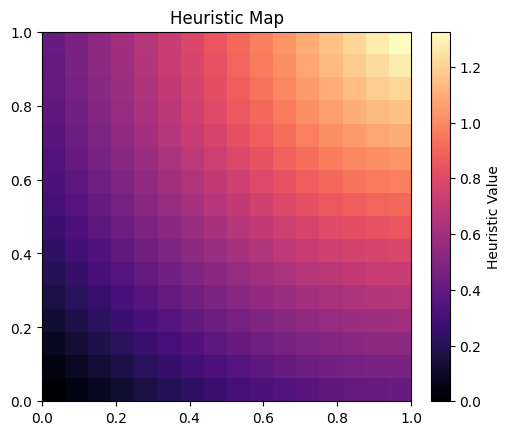

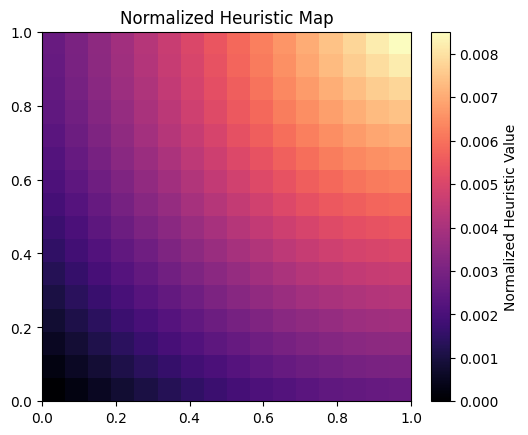

In [52]:
# overlay heuristic map
plt.imshow(heuristicMap, cmap='magma', interpolation='nearest', extent=[0, 1, 0, 1], origin='lower')
plt.colorbar(label='Heuristic Value', fraction=0.046, pad=0.04)
plt.title('Heuristic Map')
plt.show()


#overlay normalized heuristic map
plt.imshow(normalized_map, cmap='magma', interpolation='nearest', extent=[0, 1, 0, 1], origin='lower')
plt.colorbar(label='Normalized Heuristic Value', fraction=0.046, pad=0.04)
plt.title('Normalized Heuristic Map')
plt.show()

Time taken: 0.05s
Number of nodes in the tree: 206
Generation of the last node: 32


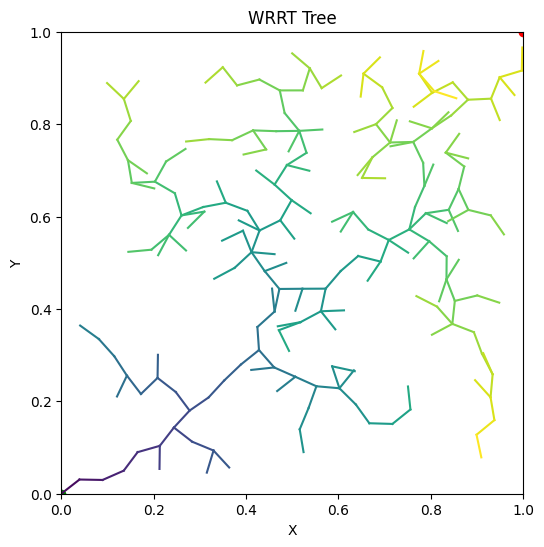

Time taken: 0.07s
Number of nodes in the tree: 254
Generation of the last node: 38


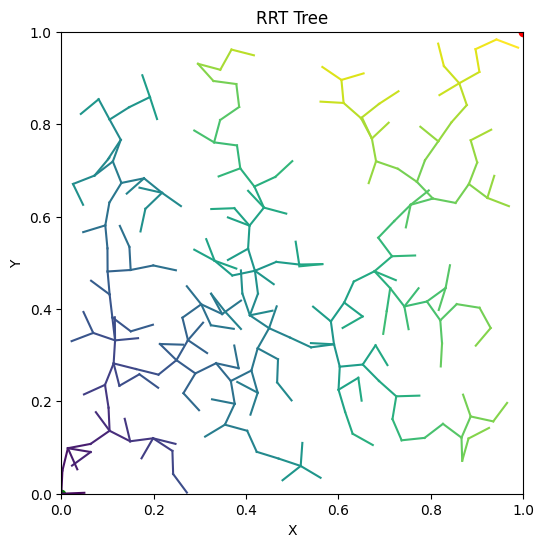

In [53]:
# run the WRRT algorithm and record the time taken
start_time = time.time()
solved = wrrt_algorithm(start, goal, goalRange, heuristicMap, distanceUnit, heuristic2coord, pick_weighted_random_cell)
tree= solved[0]

print(f"Time taken: {time.time() - start_time:.2f}s")
print(f"Number of nodes in the tree: {len(tree)}")
print(f"Generation of the last node: {solved[1]}")


# plot the tree with color coding using the generation
plt.figure(figsize=(6, 6))
plt.plot(start[0], start[1], 'go', label='Start')  # green dot for start
plt.plot(goal[0], goal[1], 'ro', label='Goal')    # red dot for goal
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('X')
plt.ylabel('Y')

for node, (parent, generation) in tree.items():
    if parent is not None:
        # color code based on generation
        color = plt.cm.viridis(generation / max(tree.values(), key=lambda x: x[1])[1])
        plt.plot([parent[0], node[0]], [parent[1], node[1]], color=color)
plt.title('WRRT Tree')
plt.show()

#Run the RRT algorithm and record the time taken
start_time = time.time()
solved = rrt_algorithm(start, goal, goalRange, distanceUnit, pick_pure_random_point)
tree= solved[0]

print(f"Time taken: {time.time() - start_time:.2f}s")
print(f"Number of nodes in the tree: {len(tree)}")
print(f"Generation of the last node: {solved[1]}")

# plot the tree with color coding using the generation
plt.figure(figsize=(6, 6))
plt.plot(start[0], start[1], 'go', label='Start')  # green dot for start
plt.plot(goal[0], goal[1], 'ro', label='Goal')    # red dot for goal
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('X')
plt.ylabel('Y')

for node, (parent, generation) in tree.items():
    if parent is not None:
        # color code based on generation
        color = plt.cm.viridis(generation / max(tree.values(), key=lambda x: x[1])[1])
        plt.plot([parent[0], node[0]], [parent[1], node[1]], color=color)

plt.title('RRT Tree')
plt.show()

## Obsticals
Now let's add obsticals. My idea right now is to do it where I can have obsticals/start/end location datastrcuture where the start and end location are points, and obsticals are a mathematical boxes/bounds where if the point we want to put is inside that area it would have to run again and try to make a new node. does this sound feasable or bad? or is there a better way

In [ ]:
obsticales = [((0.24, 0), (0.26, 0.3)), ((0.24, 0.7), (0.26, 1))]